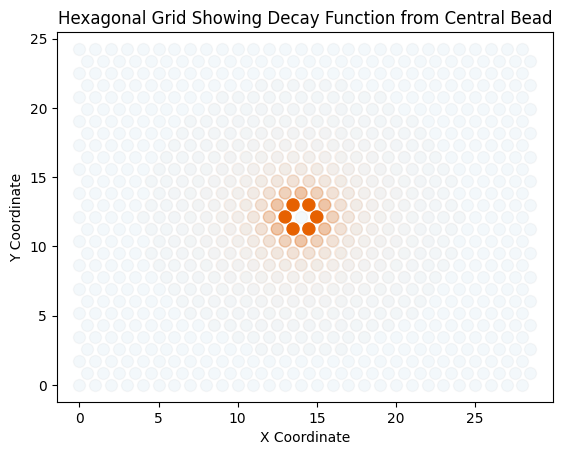

In [1]:
import pandas as pd
import numpy as np

from ssv2.simulation import BaseSimulation


simulator = BaseSimulation(29, 29)

simulator.plot_setting()


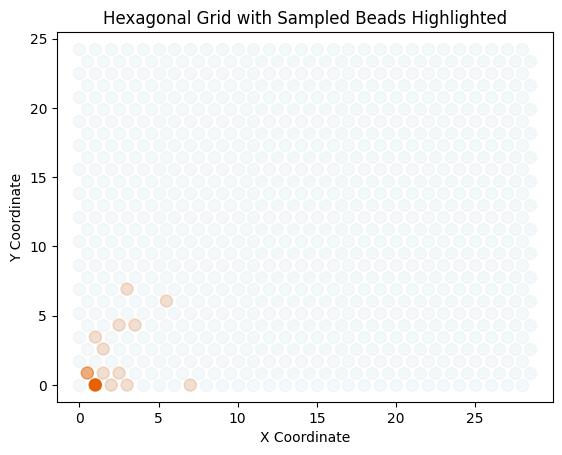

     x_coord   y_coord  dist_from_center     decay  x_displacement  \
1        1.0  0.000000          1.000000  0.175559             1.0   
2        2.0  0.000000          2.000000  0.043890             2.0   
3        3.0  0.000000          3.000000  0.019507             3.0   
7        7.0  0.000000          7.000000  0.003583             7.0   
29       0.5  0.866025          1.000000  0.175559             0.5   
30       1.5  0.866025          1.732051  0.058520             1.5   
31       2.5  0.866025          2.645751  0.025080             2.5   
88       1.5  2.598076          3.000000  0.019507             1.5   
117      1.0  3.464102          3.605551  0.013505             1.0   
147      2.5  4.330127          5.000000  0.007022             2.5   
148      3.5  4.330127          5.567764  0.005663             3.5   
208      5.5  6.062178          8.185353  0.002620             5.5   
235      3.0  6.928203          7.549834  0.003080             3.0   

     y_displacement

In [15]:
simulator.plot_sample(20, 0)